In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<style>
.output_png {
    display: table-cell;
    text-align: center;
    horizontal-align: middle;
    vertical-align: middle;
    margin:auto;
}
</style>
<form action="javascript:code_toggle()"><input type="submit"
value="Click here to toggle on/off the raw code."></form>''')

# Import Libraries

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
from sklearn.compose import ColumnTransformer
import seaborn as sns
import tqdm
from sklearn.impute import SimpleImputer
%matplotlib inline

import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm.notebook import tqdm_notebook
from collections import Counter
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.linear_model import Lasso
import shap
import optuna
from sklearn.metrics import median_absolute_error
import re
import os
from IPython.display import display, Image

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-91rlk15a because the default path (/home/gcadena/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Utility Function

In [2]:
def get_total_and_counts(df_absow, col_name, pref):
    df_amen = df_absow[[col_name, 'way']].copy().dropna()
    df_amen['way'] = df_amen['way'].copy().apply(wkt.loads)
    df_amen = gpd.GeoDataFrame(df_amen, geometry='way', crs=4326)
    df_try = gpd.sjoin(gpd.GeoDataFrame(df_mm, geometry='tile'), df_amen, predicate='contains', how='left')
    total_count = df_try.groupby('tile_number')[col_name].count().reset_index().rename(columns={col_name:f'{col_name}_count'})
    def point_counter(df_try, point_col, prefix):    
        from collections import Counter
        df_amen_counter = pd.DataFrame()
        for i in tqdm.notebook.tqdm(df_try.tile_number.unique()):
            dict_ = Counter(df_try[df_try.tile_number==i][point_col])


            prefix_dict = {}
            for key, val in dict_.items():
                prefix_dict[f'{prefix}_{key}'] = val
            prefix_dict['tile_number'] = i
            df_amen_counter = df_amen_counter.append(prefix_dict, ignore_index=True)
        return df_amen_counter

    amenities = point_counter(df_try, col_name, pref)
    df_total_and_counts = pd.merge(total_count, amenities, on='tile_number')
    return df_total_and_counts


def tune_XGBoost(X, y):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500, step=10),
        'max_depth': trial.suggest_int('max_depth', 2,15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
        
        # Classifier definition
        model = xgb.XGBRegressor(seed=20, **param)

                
        kf = KFold(n_splits=5)
        mae_list=[]
        for train_idx, val_idx in kf.split(X):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]
            
            scaler = MinMaxScaler()
            
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            model.fit(X_train_scaled, y_train)
            
            y_pred = model.predict(X_val_scaled)
            
            
            mae = mean_absolute_error(y_val, y_pred)
            mae_list.append(mae)
        
        
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize


def testing_optimal_model(model, n_trials):

    mae_list=[]
    mape_list=[]
    rmse_list=[]
    r2_list=[]
    for n in tqdm_notebook(range(n_trials)):
        (X_train, X_val, y_train, y_val) = train_test_split(X, y,
                                                              random_state=n, 
                                                              test_size=0.25)
        scaler = MinMaxScaler()

        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_val_scaled)
       


        mae = mean_absolute_error(y_val, y_pred)
    
        
        mae_list.append(mae)
    return np.mean(mae_list), mae_list


def tune_GBM(X, y):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        n_estimators = trial.suggest_int('n_estimators', 10,800, step=10)
        max_depth = trial.suggest_int('max_depth', 2,100)
        # max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        max_features = trial.suggest_int('max_features', 2, X.shape[1]-1)
        learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-1)
        
        # Classifier definition
        model = GradientBoostingRegressor(n_estimators=n_estimators,
                                           max_depth=max_depth,
                                           max_features=max_features,
                                           learning_rate=learning_rate, random_state=11)

        kf = KFold(n_splits=5)
        mae_list=[]
        for train_idx, val_idx in kf.split(X):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]
            
            scaler = MinMaxScaler()
            
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            model.fit(X_train_scaled, y_train)
            
            y_pred = model.predict(X_val_scaled)
            
            
            mae = mean_absolute_error(y_val, y_pred)
            mae_list.append(mae)
        
    
    
        
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize


def tune_RF(X, y):
    # from optuna.samplers import RandomSampler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import KFold
    
    def optimize(trial):
        # Definition of space search
        n_estimators = trial.suggest_int('n_estimators', 10,500, step=10)
        max_depth = trial.suggest_int('max_depth', 2,100)
        # max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        max_features = trial.suggest_int('max_features', 2, X.shape[1]-1)
        
        # Classifier definition
        model = RandomForestRegressor(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       max_features=max_features, random_state=11)
        kf = KFold(n_splits=5)
        mae_list=[]
        for train_idx, val_idx in kf.split(X):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]
            
            scaler = MinMaxScaler()
            
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            model.fit(X_train_scaled, y_train)
            
            y_pred = model.predict(X_val_scaled)
            
            
            mae = mean_absolute_error(y_val, y_pred)
            mae_list.append(mae)
        
        
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize


def tune_KNN(X, y):
    
    def optimize(trial):
        # Definition of space search
        n_neighbors = trial.suggest_int('n_neighbors', 2, 300, step=10)
        
        
        # Classifier definition
        model = KNeighborsRegressor(n_neighbors=n_neighbors)

        
        kf = KFold(n_splits=5)
        mae_list=[]
        for train_idx, val_idx in kf.split(X):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]
            
            scaler = MinMaxScaler()
            
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            model.fit(X_train_scaled, y_train)
            
            y_pred = model.predict(X_val_scaled)
            
            
            mae = mean_absolute_error(y_val, y_pred)
            mae_list.append(mae)
        
    
    
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize

# I. Introduction

The internet has become an inextricable part of our lives. It is used for education, to speed up daily tasks, for digital transactions, for money management, for communication, and for research and development. Proper use of this makes our lives easier, faster, and simpler. But what might be the effect if the internet connection was slower? 

In the internet quality index 2020 by Buchholz, K., &amp; Richter, F. (2021), a lot of Asian countries rank at the top with high internet speed.  However it is noticeable that the Philippines rank low in the IQI despite being surrounded by countries that rank high.  In the case of the Philippines, internet speed becomes increasingly important as having slow internet may be detrimental to businesses and individuals. 

The problem we’re facing is that internet speed is slow and understanding which locations will have better speed will be invaluable. The team wants to understand what the drivers are that could impact a faster internet speed and will use machine learning models to identify the drivers of internet speed and identify if there’s any bias of any kind.

# II. Methodology

**1. Pre-process**
<br>
The ph_point dataset’s features: amenity, building, shop, and office are transformed using one-hot-encoding. The null values for this dataset have been replaced to zero which represents that this tile doesn’t have this amenity, building, shop, or office type. For the Ookla, gadm.ph, and financial population dataset, irrelevant features were dropped.

**2. Combine Data**
<br>
The Ookla dataset and gadm.ph dataset is merged to filter out the Ookla dataset to Metro Manila province only. The merged dataset is merged again with the amenities, building, shop, offices and financial population dataset to prepare the data for the machine learning algorithm.

**3. Predict**
<br>
The team will perform different machine learning regression algorithms with the combined dataset to predict the average download speed. Interpretability methods, like SHAP, will be performed afterwards to interpret the results of the model.

# III. Data Description

The internet data was retrieved from Kaggle. The internet data are represented as Ookla Tiles with the geometry and average download speed of each tile. Another dataset used for this project is the gadm.ph dataset. This was retrieved from GADM. This dataset contains the geometries of the different cities in the Philippines with the corresponding city and province names. The last dataset used is the financial population dataset retrieved from AIM’s database. This contains the population and other financial data for provinces and cities in the Philippines.

### Ookla Dataset

The Ookla Dataset was downloaded from kaggle. The table below provides all the fields from the testing data:

<br>
<center>
       Table 1. Fields of the Ookla Dataset
</center>


| <center>Column Name</center> | <center>Data Type</center> | <center>Description</center> |
|:-|:-|:-|
|`tile`|`geometry`|Polygon representing 610.8 square meters|
|`avg_d_kbps`|`int`|The average download speed of all tests performed in the tile, represented in kilobits per second|

In [3]:
df_data = pd.read_csv('internet_data.csv', index_col=0)
df_data['tile'] = df_data['tile'].apply(wkt.loads)
df_data = gpd.GeoDataFrame(df_data, geometry='tile')
df_data = df_data.set_crs('epsg:4326')
df_data.head(2)

,quadkey,tile,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
0,320102100110313,"POLYGON ((-77.04163 38.80119, -77.03613 38.801...",232107,26768,14,27,10
1,1322122000111322,"POLYGON ((101.57959 13.88608, 101.58508 13.886...",133336,139872,6,85,12


### Postgis Dataset

The postgis dataset provided in class was used in order to help in filtering out Metro Manila in the Ookla Dataset as well as use the features `amenity`, `building`, `shop`, and `office`.

<br>
<center>
       Table 2. Fields of the gadm.ph dataset
</center>


| <center>Column Name</center> | <center>Data Type</center> | <center>Description</center> |
|:-|:-|:-|
|`name_1`|`str`|Province in the Philippines|
|`name_2`|`str`|City in the Philippines|
|`geom`|`geometry`|Polygon representing a city in the Philippines|

In [4]:
# gadm.ph data
df_ph = pd.read_csv('ph_data.csv', index_col=0)
df_ph['geom'] = df_ph['geom'].apply(wkt.loads)
df_ph = gpd.GeoDataFrame(df_ph, geometry='geom')
df_ph = df_ph.set_crs('epsg:4326')
df_ph.head(2)

,gid,gid_0,name_0,gid_1,name_1,nl_name_1,gid_2,name_2,varname_2,nl_name_2,type_2,engtype_2,cc_2,hasc_2,geom
0,1,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.1_1,Bangued,NaN,NaN,Bayan|Munisipyo,Municipality,140101.0,PH.AB.BN,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ..."
1,2,PHL,Philippines,PHL.1_1,Abra,NaN,PHL.1.2_1,Boliney,NaN,NaN,Bayan|Munisipyo,Municipality,140102.0,PH.AB.BL,"MULTIPOLYGON (((120.99042 17.39802, 120.98631 ..."


<br>
<center>
       Table 3. Fields of the ph_point dataset
</center>


| <center>Column Name</center> | <center>Data Type</center> | <center>Description</center> |
|:-|:-|:-|
|`amenity`|`str`|Types of Amenities|
|`building`|`str`|Types of Building|
|`shop`|`str`|Types of shop|
|`office`|`str`|Types of office|
|`way`|`geometry`|Coordinates of the amenity/building/shop/office|

In [5]:
# ph_point data
df_absow = pd.read_csv('amen_bldg_shop_off_way.csv', index_col=0)
df_absow.head(2)

,amenity,building,shop,office,way
0,place_of_worship,NaN,NaN,NaN,POINT (121.0650407 14.5397932)
1,NaN,NaN,NaN,NaN,POINT (121.0656832 14.5397264)


### Financial and Population Dataset

The financial and population dataset provided in class was used in order to add more features in predicting the internet speed of a city.

<br>
<center>
       Table 4. Fields of the Financial Population Dataset
</center>


| <center>Column Name</center> | <center>Data Type</center> | <center>Description</center> |
|:-|:-|:-|
|`pop`|`float`|Total population of a city in the Philippines|
|`net_oper_income`|`float`|Net operating income of a city in the Philippines|
|`shp_municipality`|`str`|Cities in the Philippines|

In [3]:
df_pop = pd.read_csv('financial_pop.csv')
df_pop.head(2)

,pop,tot_local_sources,tot_tax_revenue,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,shp_province,shp_municipality
0,48163.0,74.045920,36.556294,230.577076,206.848717,23.728359,0.0,16.202464,21.181116,15.758681,Abra,Bangued
1,3573.0,0.115667,0.035633,56.689883,54.409910,2.279973,0.0,0.000000,0.030000,20.369743,Abra,Boliney


# IV. Data Pre-processing

### Filtering Metro Manila data

In [7]:
# merging postgis and ookla dataset to add tiles
df_merged = gpd.sjoin(df_ph, df_data, how='left', predicate='contains')

df_conso = pd.merge(df_merged.rename(columns={'index_right':'index'}),
                    df_data.reset_index()[['index','tile']],
                    how='left', on='index')

#d roping not needed columns
df_trim = df_conso.drop(columns=['gid', 'gid_0', 'name_0', 'gid_1',
                                 'nl_name_1', 'gid_2', 'varname_2',
                                 'nl_name_2', 'cc_2', 'hasc_2'])

df_trim.head(2)

,name_1,name_2,type_2,engtype_2,geom,index,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,tile
0,Abra,Bangued,Bayan|Munisipyo,Municipality,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",166904.0,1.323012e+15,53586.0,46808.0,17.0,39.0,7.0,"POLYGON ((120.61340 17.58119, 120.61890 17.581..."
1,Abra,Bangued,Bayan|Munisipyo,Municipality,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ...",684659.0,1.323012e+15,96949.0,90962.0,14.0,20.0,8.0,"POLYGON ((120.61340 17.59167, 120.61890 17.591..."


In [8]:
df_mm = df_trim[df_trim['name_1']=='Metropolitan Manila']
df_mm.head(2)

,name_1,name_2,type_2,engtype_2,geom,index,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,tile
43982,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",36370.0,1.323031e+15,77094.0,84609.0,8.0,3775.0,692.0,"POLYGON ((121.06384 14.54637, 121.06934 14.546..."
43983,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",94071.0,1.323031e+15,81364.0,83144.0,5.0,3439.0,604.0,"POLYGON ((121.06934 14.55168, 121.07483 14.551..."


### Loading Financial Data

In [9]:
# merge dataset to 
df_mm= df_mm.merge(df_pop,
                   left_on = ['name_1','name_2'],
                   right_on = ['shp_province','shp_municipality'])

# dropping not needed columns
df_mm = df_mm.drop(columns=['index', 'quadkey'])

# adding tile id
df_mm['tile_number'] = range(1, df_mm.shape[0]+1)
df_mm.head(2)

,name_1,name_2,type_2,engtype_2,geom,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,...,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,shp_province,shp_municipality,tile_number
0,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",77094.0,84609.0,8.0,3775.0,692.0,...,201.599229,163.300161,38.299068,0.0,1.48214,4.54614,62.811989,Metropolitan Manila,Pateros,1
1,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",81364.0,83144.0,5.0,3439.0,604.0,...,201.599229,163.300161,38.299068,0.0,1.48214,4.54614,62.811989,Metropolitan Manila,Pateros,2


### Plotting Philippines with the tiles

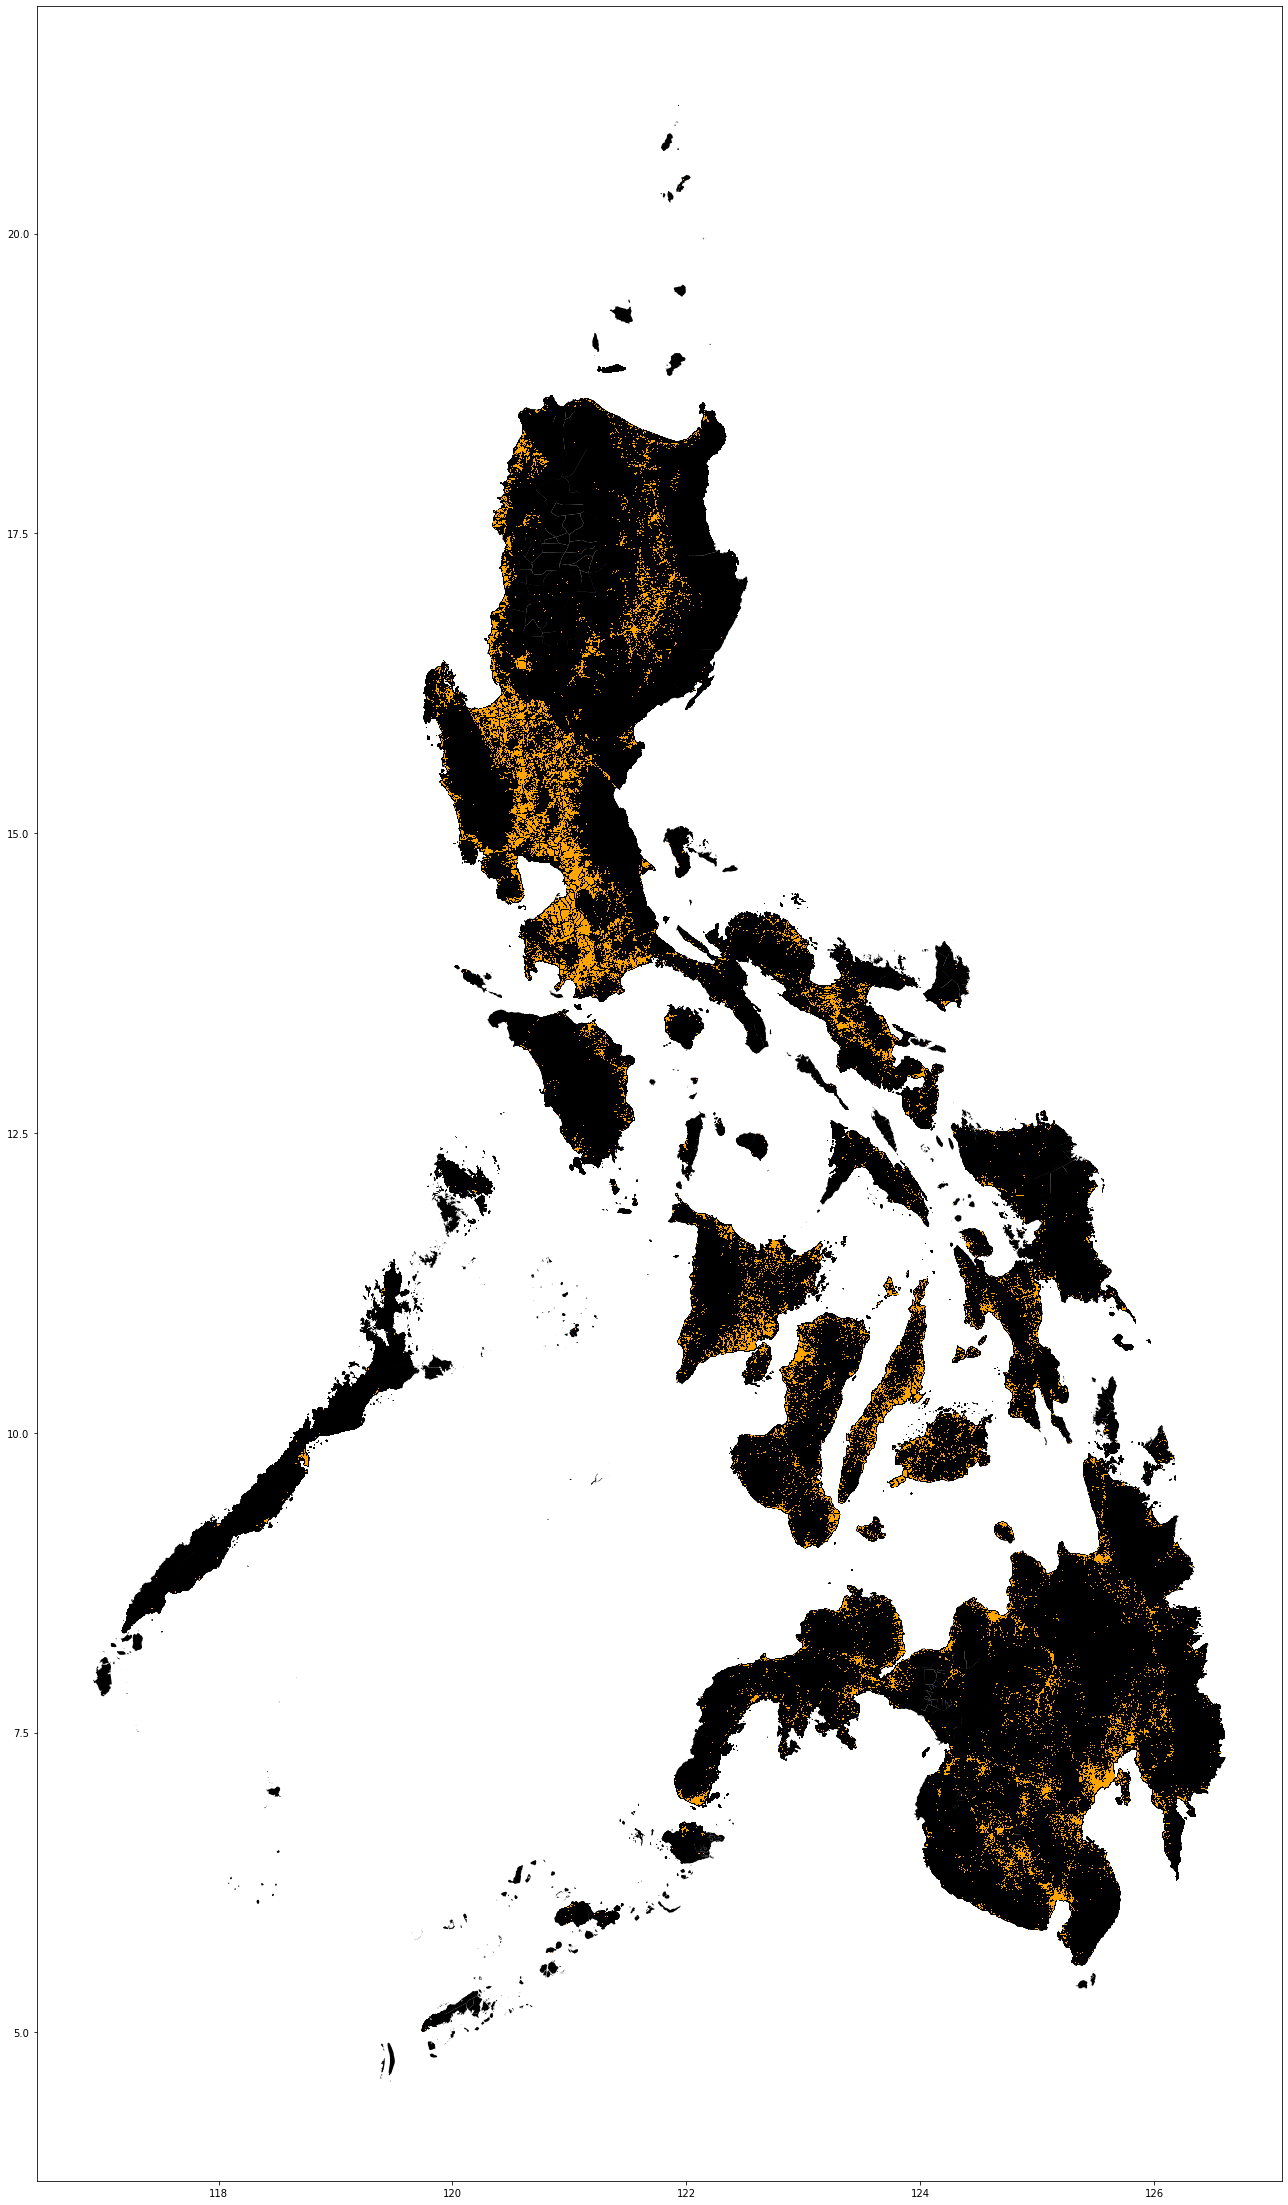

In [10]:
fig, ax = plt.subplots(figsize=(50,40))
df_trim['geom'].plot(ax=ax, color='black')
df_trim['tile'].plot(ax=ax, color='orange')
plt.savefig('ph')

### Plotting Manila with the tiles

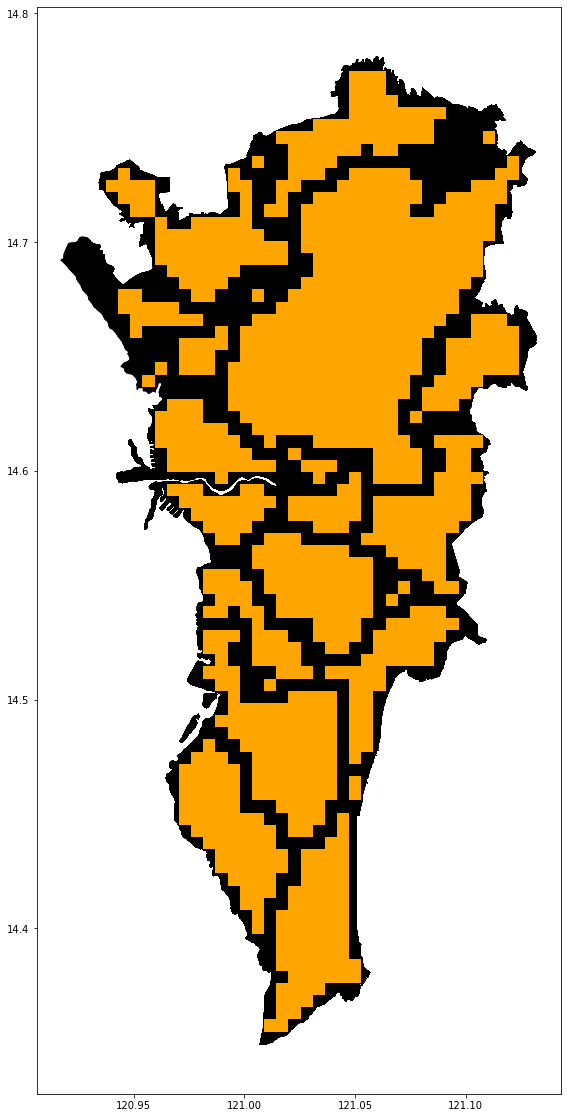

In [11]:
fig, ax = plt.subplots(figsize=(30,20))

df_mm['geom'].plot(ax=ax, color='black')
df_mm['tile'].plot(ax=ax, color='orange')
plt.savefig('metromanila')

### Getting the total counts of amenities, buildings, offices, and shops in a city in Metro Manila.

In [12]:
amen = get_total_and_counts(df_absow, 'amenity', 'amen')
amen

  0%|          | 0/1041 [00:00<?, ?it/s]

,tile_number,amenity_count,amen_restaurant,amen_fast_food,amen_school,amen_bank,amen_place_of_worship,amen_clinic,amen_tricycle_station,amen_fuel,...,amen_bus_stop,"amen_McKinley Hill, Taguig",amen_car_service,amen_internet,amen_hardware_store,amen_animal_boarding,amen_atm;fountain,amen_hackerspace,amen_emergency_service,amen_generic building
0,1,32,5.0,6.0,3.0,9.0,3.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,6,NaN,1.0,1.0,2.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1037,3,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,1038,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,1039,14,2.0,1.0,NaN,8.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039,1040,2,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
building = get_total_and_counts(df_absow, 'building', 'bldg')
building

  0%|          | 0/1041 [00:00<?, ?it/s]

,tile_number,building_count,bldg_nan,bldg_yes,bldg_hangar,bldg_house,bldg_residential,bldg_university,bldg_manufacture,bldg_commercial,...,bldg_retail,bldg_roof,bldg_dormitory,bldg_public,bldg_warehouse,bldg_store,bldg_construction,bldg_garage,"bldg_East Tower, Philippine Stock Exchange","bldg_West Tower, Philippine Stock Exchange"
0,1,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1037,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,1038,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,1039,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039,1040,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
office = get_total_and_counts(df_absow, 'office', 'ofc')
office

  0%|          | 0/1041 [00:00<?, ?it/s]

,tile_number,office_count,ofc_nan,ofc_government,ofc_accountant,ofc_company,ofc_yes,ofc_employment_agency,ofc_ngo,ofc_lawyer,...,ofc_telecommunication,ofc_school,ofc_advertising_agency,ofc_architect,ofc_political_party,ofc_construction_company,ofc_water_utility,ofc_publisher,ofc_Flcapili and Associates - 4092 Airport Road Baclaran Parañaque,ofc_administrative
0,1,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1037,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,1038,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,1039,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039,1040,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
shop = get_total_and_counts(df_absow, 'shop', 'shp')
shop

  0%|          | 0/1041 [00:00<?, ?it/s]

,tile_number,shop_count,shp_convenience,shp_supermarket,shp_car_parts,shp_hardware,shp_optician,shp_bicycle,shp_car,shp_electronics,...,shp_office_supplies,shp_various,shp_printhouse,shp_fabric,shp_water_station,shp_business_services,shp_printing,shp_travel_agent,shp_ASCI,shp_antiques
0,1,23,4.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1037,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,1038,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,1039,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039,1040,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_mm_amen = pd.merge(df_mm, amen, on='tile_number')
df_mm_amen_off = pd.merge(df_mm_amen, office, on='tile_number')
df_mm_amen_off_shp = pd.merge(df_mm_amen_off, shop, on='tile_number')
df_mm_amen_off_shp_bldg = pd.merge(df_mm_amen_off_shp, building, on='tile_number')
df_mm_amen_off_shp_bldg

,name_1,name_2,type_2,engtype_2,geom,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,...,bldg_retail,bldg_roof,bldg_dormitory,bldg_public,bldg_warehouse,bldg_store,bldg_construction,bldg_garage,"bldg_East Tower, Philippine Stock Exchange","bldg_West Tower, Philippine Stock Exchange"
0,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",77094.0,84609.0,8.0,3775.0,692.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",81364.0,83144.0,5.0,3439.0,604.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",75314.0,67335.0,6.0,926.0,185.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",77048.0,62828.0,7.0,531.0,123.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",79002.0,73963.0,6.0,272.0,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",69291.0,67368.0,6.0,1376.0,314.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",62021.0,60313.0,6.0,916.0,183.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",79729.0,82733.0,6.0,1080.0,253.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",68750.0,69533.0,6.0,1271.0,277.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Combining all the datasets

In [17]:
df_ML = pd.concat([df_mm_amen_off_shp_bldg, pd.get_dummies(df_mm_amen_off_shp_bldg['name_2'])], axis=1)
df_ML

,name_1,name_2,type_2,engtype_2,geom,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,...,Muntinlupa,Navotas,Parañaque,Pasay City,Pasig City,Pateros,Quezon City,San Juan,Taguig,Valenzuela
0,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",77094.0,84609.0,8.0,3775.0,692.0,...,0,0,0,0,0,1,0,0,0,0
1,Metropolitan Manila,Pateros,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",81364.0,83144.0,5.0,3439.0,604.0,...,0,0,0,0,0,1,0,0,0,0
2,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",75314.0,67335.0,6.0,926.0,185.0,...,0,0,0,0,0,0,1,0,0,0
3,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",77048.0,62828.0,7.0,531.0,123.0,...,0,0,0,0,0,0,1,0,0,0
4,Metropolitan Manila,Quezon City,Lungsod|Siyudad,City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",79002.0,73963.0,6.0,272.0,86.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",69291.0,67368.0,6.0,1376.0,314.0,...,0,0,0,0,0,0,0,0,0,1
1037,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",62021.0,60313.0,6.0,916.0,183.0,...,0,0,0,0,0,0,0,0,0,1
1038,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",79729.0,82733.0,6.0,1080.0,253.0,...,0,0,0,0,0,0,0,0,0,1
1039,Metropolitan Manila,Valenzuela,Lungsod|Siyudad,City,"MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...",68750.0,69533.0,6.0,1271.0,277.0,...,0,0,0,0,0,0,0,0,0,1


# V. Exploratory Data Analysis

### Metro Manila Average Speed

The average internet speed in Metro Manila is at 66.41mbps which is super slow compared to neighboring asian countries like Singapore at 245.50mbps, South Korea at 241.58 mbps and Hong Kong at 240.83mbps.

In [20]:
df_ML.drop(columns='tile')[['name_2','geom', 'avg_d_kbps']].dissolve('name_2', aggfunc='mean').mean()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


avg_d_kbps    66414.930204
dtype: float64

### Average Internet Speed per City

The plot below shows a heatmap of the average download speed throughout Metro Manila on a city level. A darker color means the internet speed is low while a lighter color means a fast internet speed. It can be observed that San Juan, Pateros, Marikina and Makati City are some of the cities that have fast internet speed in Metro Manila while Navotas, Pasay City, and Valenzuela have a low internet speed.

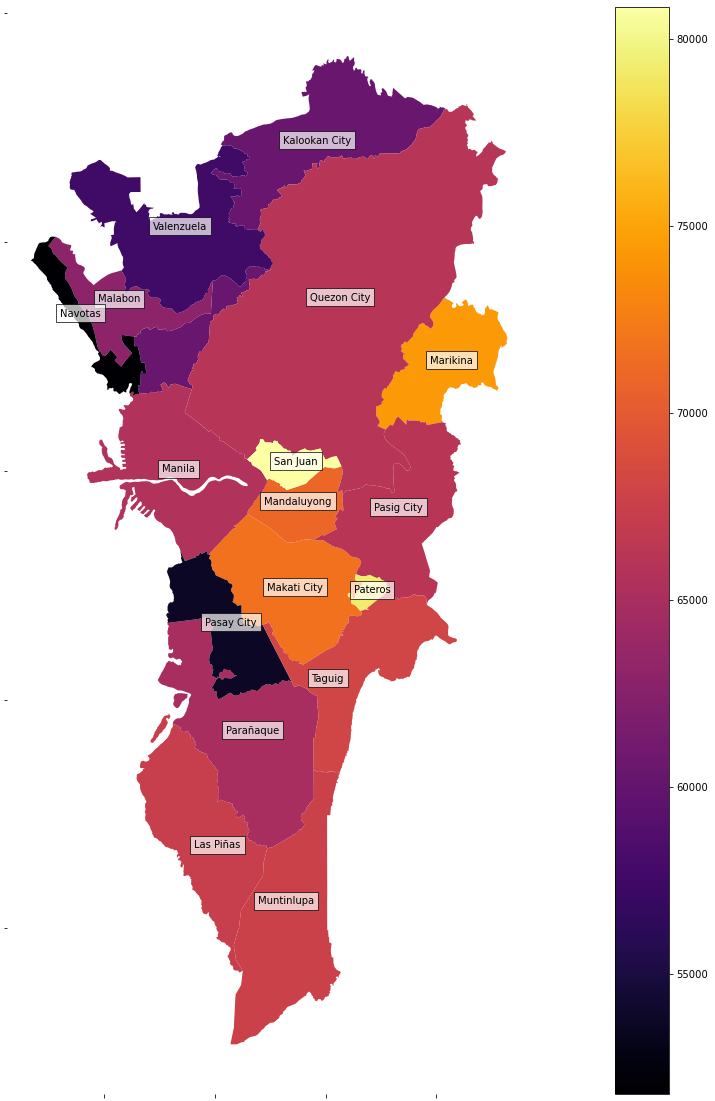

In [21]:
fig, ax = plt.subplots(figsize=(30,20))
gpd.GeoDataFrame(df_ML.drop(columns='tile')[['name_2','geom', 'avg_d_kbps']].dissolve('name_2', aggfunc='mean'), geometry='geom').plot(ax=ax, column='avg_d_kbps', cmap='inferno', legend=True)
for idx, row in df_diss.iterrows():
    plt.annotate(text=idx, xy=row['coords'],
                 horizontalalignment='center', color='black', bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))

for key, spine in ax.spines.items():
    spine.set_visible(False)

ax.set_xticklabels([])
ax.set_yticklabels([]);

### Average Internet Speed per Tile

The plot below shows a heatmap of the average internet speed in Metro Manila on a per tile level. A cooler color indicates a fast internet speed in that tile while a warmer color indicates otherwise. Most fast internet speed tiles are found in Makati City and Muntinlupa while low internet speed tiles are found in Pasay City and Muntinlupa as well.

In [18]:
df_diss = df_ML[['name_2', 'geom']].dissolve('name_2')
df_diss

,geom
name_2,
Kalookan City,"MULTIPOLYGON (((120.97936 14.63645, 120.97897 ..."
Las Piñas,"MULTIPOLYGON (((120.99390 14.41149, 120.99390 ..."
Makati City,"POLYGON ((121.06602 14.53700, 121.06582 14.536..."
Malabon,"POLYGON ((120.95795 14.65777, 120.95798 14.657..."
Mandaluyong,"POLYGON ((121.05328 14.57371, 121.05292 14.573..."
Manila,"POLYGON ((120.98614 14.56120, 120.98525 14.563..."
Marikina,"POLYGON ((121.07373 14.62295, 121.07359 14.623..."
Muntinlupa,"POLYGON ((121.02247 14.35672, 121.02242 14.356..."
Navotas,"POLYGON ((120.96139 14.63389, 120.96139 14.635..."


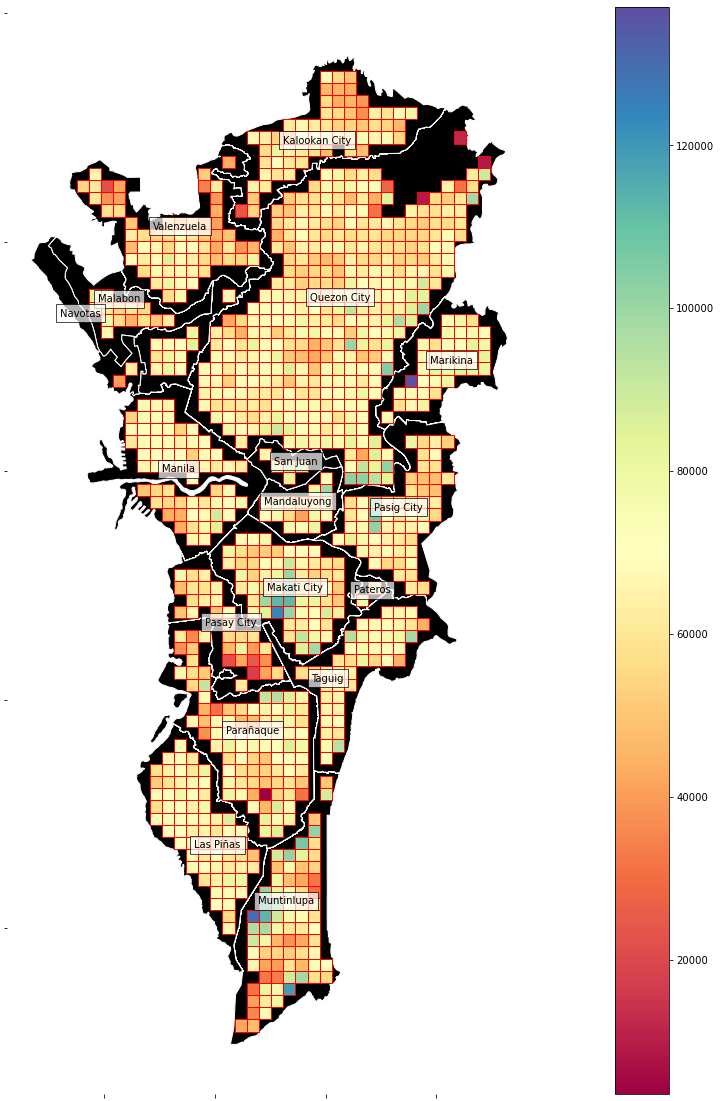

In [19]:
fig, ax = plt.subplots(figsize=(30,20))
df_diss['coords'] = df_diss['geom'].apply(lambda x: x.representative_point().coords[:])
df_diss['coords'] = [coords[0] for coords in df_diss['coords']]
for idx, row in df_diss.iterrows():
    plt.annotate(text=idx, xy=row['coords'],
                 horizontalalignment='center', color='black', bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))
gpd.GeoDataFrame(df_ML, geometry='geom').plot(ax=ax, edgecolor='white', color='black')
gpd.GeoDataFrame(df_ML, geometry='tile').plot(ax=ax, edgecolor='red', column='avg_d_kbps', cmap='Spectral', legend=True)
for key, spine in ax.spines.items():
    spine.set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('tiles.png')

# VI. Machine Learning

<b>Machine Learning Regression Models</b><br>
Once the data has been cleaned, formatted and engineered, setting up the pipeline for machine learning regression is performed. The data is split into train-val and test splits. Seventy-five percent of the data is used for training and validation, while the remaining twenty-five percent is used for testing. A total of four regression models were tuned and tested for this project namely, XGBoost, Gradient Boosting Method (GBM), Random Forest, and K-nearest Neighbors (KNN). 

<b>Performance Metric</b><br>
The chosen performance metric for this project is the Mean Absolute Error (MAE). MAE is chosen as it is a standard metric for regression problems and it is very intuitive and easy to communicate with stakeholders as it represents the error in the same units as the target variable.

<br>
<center><b>Equation 1. Mean Absolute Error</b><br>
$$\sum_{i=1}^{D}|x_i-y_i|$$</center>

<b>Cross-Validation</b><br>
There are two types of cross-validation performed, one for hyperparameter tuning and another for testing. It is also important to note that a min-max scaler was used on both tuning and testing procedures. 

<b>Hyperparameter Tuning</b><br>
We used Optuna as the hyperparameter tuning framework for this study.  A 5-fold cross validation strategy is also used. A second splitting is performed on the train-val set to extract the train and validation sets for the 5-fold cross-validation. Tables 4-6 shows the hyperparameter ranges used for each of the models evaluated. Lastly, all models we’re tuned using 1000 Optuna trials and a random state of 11 if applicable.

<b>Testing</b><br>
A monte carlo cross-validation strategy is used for cross-validating the MAEs when testing the tuned model on the test set. A total of 20 trials are used for this strategy. 

### Splitting

In [46]:
X = df_ML[df_ML.columns.difference(['name_1', 'name_2', 'type_2', 'engtype_2',
                                    'geom', 'shp_province', 'shp_municipality',
                                    'avg_u_kbps', 'tile', 'avg_lat_ms', 'quadkey',
                                    'avg_d_kbps', 'tile_number', 'amen_nan', 'ofc_nan', 'bldg_nan', 'shp_nan', 'devices', 'tests'])]
X = X.fillna(0)
y = df_ML['avg_d_kbps']

In [48]:
X_nocity.columns.to_list()

['amen_BPI ATM',
 'amen_Highway',
 'amen_McKinley Hill, Taguig',
 'amen_Uload Phils',
 'amen_adult_gaming_centre',
 'amen_airline_office',
 'amen_animal_boarding',
 'amen_arcade',
 'amen_arts_centre',
 'amen_atm',
 'amen_atm;fountain',
 'amen_bank',
 'amen_bank;restaurant',
 'amen_bar',
 'amen_bar;restaurant',
 'amen_bbq',
 'amen_bench',
 'amen_bicycle_parking',
 'amen_bicycle_rental',
 'amen_bicycle_repair_station',
 'amen_biergarten',
 'amen_building',
 'amen_bureau_de_change',
 'amen_bus_station',
 'amen_bus_stop',
 'amen_cafe',
 'amen_car_rental',
 'amen_car_service',
 'amen_car_sharing',
 'amen_car_wash',
 'amen_casino',
 'amen_charging_station',
 'amen_childcare',
 'amen_cinema',
 'amen_clinic',
 'amen_clock',
 'amen_college',
 'amen_commercial',
 'amen_community_centre',
 'amen_computer_rental',
 'amen_condominium',
 'amen_conference_centre',
 'amen_courier',
 'amen_court_house',
 'amen_courthouse',
 'amen_coworking_space',
 'amen_dancing_school',
 'amen_dentist',
 'amen_doctors

In [50]:
X_nocity = X.drop(['Kalookan City', 'Las Piñas', 'Makati City', 'Malabon',
                   'Mandaluyong', 'Manila', 'Marikina', 'Muntinlupa',
                   'Navotas', 'Parañaque', 'Pasay City', 'Pasig City',
                   'Pateros', 'Quezon City', 'San Juan', 'Taguig',
                   'Valenzuela','capital_expenditure', 'cash_balance_end',
                   'tot_current_oper_income','tot_local_sources',
                'tot_tax_revenue',
                 'total_non_income_receipts',
             'total_non_oper_expenditures',
                 'total_oper_expenses'
                   ], axis=1)

In [ ]:
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25)

### XGBoost

In [ ]:
xgb_study, xgb_optimize = tune_XGBoost(X_trainval, y_trainval)

In [ ]:
xgb_study.best_params

In [ ]:
xgb_study.best_value

In [ ]:
xgb_study.best_trial.number

In [ ]:
xgb_model = xgb.XGBRegressor(seed=20, **xgb_study.best_params)
xgb_test_mae, xgb_mae_list = testing_optimal_model(xgb_model, 20)
xgb_test_mae
# 4234

### GBM

In [ ]:
gbm_study, gbm_optimize = tune_GBM(X_trainval, y_trainval)

In [ ]:
display(gbm_study.best_trial)
display(gbm_study.best_value)
display(gbm_study.best_params)

In [ ]:
gbm_model = GradientBoostingRegressor(random_state=11, **gbm_study.best_params)
gbm_test_mae, gbm_mae_list = testing_optimal_model(gbm_model, 20)
gbm_test_mae
# 4234

### Random Forest

In [58]:
rf_study, rf_optimize = tune_RF(X_trainval, y_trainval)

[I 2021-12-13 15:59:52,958] Trial 0 finished with value: 10072.146160729422 and parameters: {'n_estimators': 170, 'max_depth': 57, 'max_features': 159}. Best is trial 0 with value: 10072.146160729422.
[I 2021-12-13 15:59:55,470] Trial 1 finished with value: 10066.814728475716 and parameters: {'n_estimators': 150, 'max_depth': 32, 'max_features': 250}. Best is trial 1 with value: 10066.814728475716.
[I 2021-12-13 16:00:02,327] Trial 4 finished with value: 10012.397507554462 and parameters: {'n_estimators': 140, 'max_depth': 38, 'max_features': 49}. Best is trial 4 with value: 10012.397507554462.
[I 2021-12-13 16:00:12,903] Trial 2 finished with value: 10110.396300652064 and parameters: {'n_estimators': 240, 'max_depth': 93, 'max_features': 327}. Best is trial 4 with value: 10012.397507554462.
[I 2021-12-13 16:00:16,129] Trial 6 finished with value: 10046.49226966473 and parameters: {'n_estimators': 180, 'max_depth': 54, 'max_features': 76}. Best is trial 4 with value: 10012.397507554462

[I 2021-12-13 16:04:25,460] Trial 40 finished with value: 10022.170868239891 and parameters: {'n_estimators': 460, 'max_depth': 97, 'max_features': 39}. Best is trial 23 with value: 9920.618104510884.
[I 2021-12-13 16:04:32,888] Trial 38 finished with value: 10045.163887396138 and parameters: {'n_estimators': 450, 'max_depth': 28, 'max_features': 171}. Best is trial 23 with value: 9920.618104510884.
[I 2021-12-13 16:04:39,059] Trial 42 finished with value: 10083.18049946294 and parameters: {'n_estimators': 290, 'max_depth': 11, 'max_features': 43}. Best is trial 23 with value: 9920.618104510884.
[I 2021-12-13 16:04:45,354] Trial 41 finished with value: 10052.398222753323 and parameters: {'n_estimators': 390, 'max_depth': 96, 'max_features': 44}. Best is trial 23 with value: 9920.618104510884.
[I 2021-12-13 16:04:50,900] Trial 43 finished with value: 9930.059845839774 and parameters: {'n_estimators': 300, 'max_depth': 13, 'max_features': 126}. Best is trial 23 with value: 9920.618104510

[I 2021-12-13 16:09:47,332] Trial 78 finished with value: 9972.365853732616 and parameters: {'n_estimators': 440, 'max_depth': 19, 'max_features': 123}. Best is trial 23 with value: 9920.618104510884.
[I 2021-12-13 16:09:47,351] Trial 79 finished with value: 9977.98042991817 and parameters: {'n_estimators': 440, 'max_depth': 18, 'max_features': 123}. Best is trial 23 with value: 9920.618104510884.
[I 2021-12-13 16:09:54,092] Trial 80 finished with value: 9937.07652564347 and parameters: {'n_estimators': 440, 'max_depth': 20, 'max_features': 122}. Best is trial 23 with value: 9920.618104510884.
[I 2021-12-13 16:10:03,279] Trial 82 finished with value: 10076.1376163212 and parameters: {'n_estimators': 140, 'max_depth': 31, 'max_features': 179}. Best is trial 23 with value: 9920.618104510884.
[I 2021-12-13 16:10:14,424] Trial 81 finished with value: 10042.587140056581 and parameters: {'n_estimators': 440, 'max_depth': 19, 'max_features': 293}. Best is trial 23 with value: 9920.61810451088

[I 2021-12-13 16:15:21,817] Trial 117 finished with value: 10129.082536002888 and parameters: {'n_estimators': 480, 'max_depth': 6, 'max_features': 142}. Best is trial 87 with value: 9914.467320792706.
[I 2021-12-13 16:15:53,057] Trial 118 finished with value: 9970.738729790774 and parameters: {'n_estimators': 470, 'max_depth': 19, 'max_features': 149}. Best is trial 87 with value: 9914.467320792706.
[I 2021-12-13 16:15:59,272] Trial 119 finished with value: 9975.514275077145 and parameters: {'n_estimators': 470, 'max_depth': 18, 'max_features': 134}. Best is trial 87 with value: 9914.467320792706.
[I 2021-12-13 16:16:00,103] Trial 121 finished with value: 9928.301822356289 and parameters: {'n_estimators': 470, 'max_depth': 18, 'max_features': 108}. Best is trial 87 with value: 9914.467320792706.
[I 2021-12-13 16:16:04,323] Trial 120 finished with value: 9978.759630657001 and parameters: {'n_estimators': 470, 'max_depth': 18, 'max_features': 148}. Best is trial 87 with value: 9914.4673

[I 2021-12-13 16:20:30,213] Trial 157 finished with value: 9937.99020597078 and parameters: {'n_estimators': 270, 'max_depth': 14, 'max_features': 59}. Best is trial 144 with value: 9908.849962682176.
[I 2021-12-13 16:20:30,222] Trial 155 finished with value: 9962.262695802518 and parameters: {'n_estimators': 390, 'max_depth': 18, 'max_features': 57}. Best is trial 144 with value: 9908.849962682176.
[I 2021-12-13 16:20:51,543] Trial 161 finished with value: 9996.578648152974 and parameters: {'n_estimators': 330, 'max_depth': 10, 'max_features': 93}. Best is trial 144 with value: 9908.849962682176.
[I 2021-12-13 16:20:51,951] Trial 160 finished with value: 9982.734445826367 and parameters: {'n_estimators': 330, 'max_depth': 11, 'max_features': 91}. Best is trial 144 with value: 9908.849962682176.
[I 2021-12-13 16:20:52,297] Trial 159 finished with value: 10018.479108234358 and parameters: {'n_estimators': 340, 'max_depth': 76, 'max_features': 59}. Best is trial 144 with value: 9908.8499

[I 2021-12-13 16:24:03,373] Trial 196 finished with value: 9943.23405866604 and parameters: {'n_estimators': 300, 'max_depth': 14, 'max_features': 121}. Best is trial 144 with value: 9908.849962682176.
[I 2021-12-13 16:24:06,080] Trial 197 finished with value: 9921.180735453187 and parameters: {'n_estimators': 290, 'max_depth': 14, 'max_features': 116}. Best is trial 144 with value: 9908.849962682176.
[I 2021-12-13 16:24:08,750] Trial 195 finished with value: 9936.196734731797 and parameters: {'n_estimators': 500, 'max_depth': 14, 'max_features': 80}. Best is trial 144 with value: 9908.849962682176.
[I 2021-12-13 16:24:11,791] Trial 198 finished with value: 9949.05371345922 and parameters: {'n_estimators': 320, 'max_depth': 14, 'max_features': 94}. Best is trial 144 with value: 9908.849962682176.
[I 2021-12-13 16:24:17,005] Trial 199 finished with value: 9986.088627377127 and parameters: {'n_estimators': 320, 'max_depth': 21, 'max_features': 95}. Best is trial 144 with value: 9908.8499

In [59]:
display(rf_study.best_trial)
display(rf_study.best_value)
display(rf_study.best_params)

FrozenTrial(number=144, values=[9908.849962682176], datetime_start=datetime.datetime(2021, 12, 13, 16, 18, 40, 335028), datetime_complete=datetime.datetime(2021, 12, 13, 16, 19, 11, 702534), params={'n_estimators': 420, 'max_depth': 14, 'max_features': 100}, distributions={'n_estimators': IntUniformDistribution(high=500, low=10, step=10), 'max_depth': IntUniformDistribution(high=100, low=2, step=1), 'max_features': IntUniformDistribution(high=358, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=144, state=TrialState.COMPLETE, value=None)

9908.849962682176

{'n_estimators': 420, 'max_depth': 14, 'max_features': 100}

In [60]:
rf_model = RandomForestRegressor(random_state=11, **rf_study.best_params)
rf_test_mae, rf_mae_list = testing_optimal_model(rf_model, 20)
rf_test_mae

  0%|          | 0/20 [00:00<?, ?it/s]

10016.371830178912

### KNN

In [ ]:
knn_study, knn_optimize = tune_KNN(X_trainval, y_trainval)

[I 2021-12-13 15:56:55,931] A new study created in memory with name: no-name-10c501c0-371e-49f7-b94d-d8f229886953
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:56:58,533] Trial 3 finished with value: 12355.28205128205 and parameters: {'n_neighbors': 2}. Best is trial 3 with value: 12355.28205128205.
The distribution is specified by [2, 300] and step=10, but th

The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:57:16,419] Trial 25 finished with value: 10550.461106879919 and parameters: {'n_neighbors': 202}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:57:17,021] Trial 27 finished with value: 10562.975360245817 and parameters: {'n_neighbors': 242}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:57:17,038] Trial 26 finished with value: 10562.975360245817 and parameters: {'n_neighbors': 242}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [

The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:57:36,666] Trial 52 finished with value: 10557.706943628891 and parameters: {'n_neighbors': 262}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:57:37,523] Trial 53 finished with value: 10607.52209281329 and parameters: {'n_neighbors': 142}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:57:37,834] Trial 54 finished with value: 10565.88872242099 and parameters: {'n_neighbors': 172}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2,

The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:57:58,042] Trial 79 finished with value: 10581.266880341882 and parameters: {'n_neighbors': 162}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:57:58,639] Trial 81 finished with value: 10581.266880341882 and parameters: {'n_neighbors': 162}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:57:58,934] Trial 80 finished with value: 10581.266880341882 and parameters: {'n_neighbors': 162}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [

The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:58:18,024] Trial 106 finished with value: 10541.799111912394 and parameters: {'n_neighbors': 192}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:58:18,928] Trial 107 finished with value: 10541.799111912394 and parameters: {'n_neighbors': 192}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:58:19,327] Trial 108 finished with value: 10541.799111912394 and parameters: {'n_neighbors': 192}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced b

The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:58:39,020] Trial 133 finished with value: 10565.88872242099 and parameters: {'n_neighbors': 172}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:58:39,622] Trial 134 finished with value: 10565.88872242099 and parameters: {'n_neighbors': 172}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:58:41,330] Trial 135 finished with value: 10565.88872242099 and parameters: {'n_neighbors': 172}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [

The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:59:00,725] Trial 160 finished with value: 10541.799111912394 and parameters: {'n_neighbors': 192}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:59:01,036] Trial 161 finished with value: 10550.461106879919 and parameters: {'n_neighbors': 202}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-13 15:59:01,635] Trial 162 finished with value: 10550.461106879919 and parameters: {'n_neighbors': 202}. Best is trial 2 with value: 10541.799111912394.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced b

In [ ]:
display(knn_study.best_trial)
display(knn_study.best_value)
display(knn_study.best_params)

In [ ]:
knn_model = KNeighborsRegressor(**knn_study.best_params)
knn_test_mae, knn_mae_list = testing_optimal_model(knn_model, 20)
knn_test_mae

### ML Summary

In [61]:
df_ml_summary = pd.DataFrame([[xgb_test_mae, xgb_study.best_value][::-1],
              [rf_test_mae, rf_study.best_value][::-1],
              [gbm_test_mae, gbm_study.best_value][::-1],
              [knn_test_mae, knn_study.best_value][::-1],
              ], 
             index=['XGBoost', 'Random Forest', 'GBM', 'KNN'],
             columns=['Avg Test MAE', 'Avg Val MAE'][::-1]
             )
df_ml_summary

,Avg Val MAE,Avg Test MAE
XGBoost,9899.848102,10084.979414
Random Forest,9908.849963,10016.371830
GBM,10032.405928,10040.514227
KNN,10541.799112,10754.828532


The table above shows the average validation and test MAEs for all four regression models. Random Forest produced the best MAE of 10,016.37. This means that Random Forest can accurately predict an average download speed of an Ookla tile with a 10.016 Mbps error. To explain the model’s results, we can now use SHAP. 

### SHAP on XGboost

<b>Features that drive internet speed</b><br>
When the models were run using amenities, office buildings, population, and net operating income, MAE was around 10,016.37. The plot below shows that in most cases, lower population count is the highest driver, however it is not fully consistent as there are times that cities having lower population have slower speed.  Followed by having higher net operating income correlates to higher speed.  Third is having less amenities reflects a higher internet speed, which is probably caused by less business competing for bandwidth.

In [40]:
np.argmin(rf_mae_list)

1

In [62]:
(X_train, X_val, y_train, y_val) = train_test_split(X_nocity, y,
                                                      random_state=0, 
                                                      test_size=0.25)
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_val_scaled)



mae = mean_absolute_error(y_val, y_pred)
mae

9637.50483660615

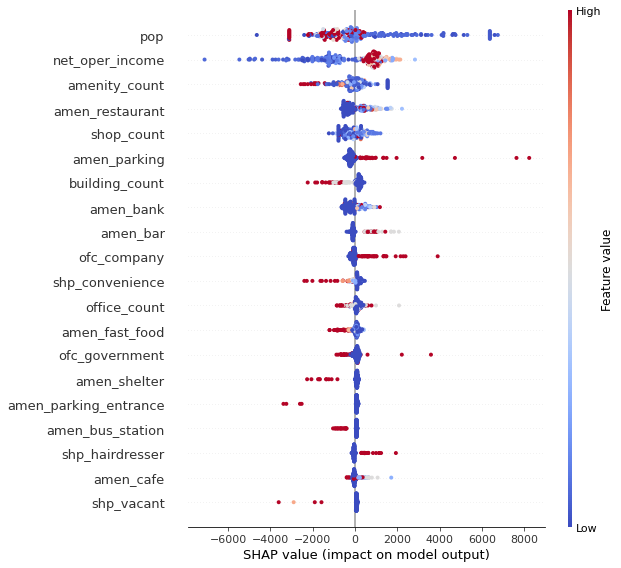

In [63]:
explainer_xgb = shap.TreeExplainer(rf_model)
shap_values = explainer_xgb.shap_values(X_val_scaled)
shap.summary_plot(shap_values = shap_values, features = X_val_scaled, 
                  feature_names=X_val.columns,
                  max_display=20, cmap='coolwarm', show=False)
#plt.savefig('beeswarm.png')

# VII. Conclusion

Looking at the different results, it can be concluded that being in a location with less population tends to give higher internet speed which can be reinforced if the city has a higher net operating income.  However, there seemed to be some biases on different cities as being in Valenzuela and Pasay tends to give lower internet speed while it’s favorable for those in Makati city.  Amenities count per tile however don’t seem to drive an increase in internet speed.  Having lower office and building counts then to drive the internet speed in the tile, which may indicate that there are less people working that need to compete for internet speed.  If city biases are ignored, the error of the prediction will go higher which will lead us to assume that being in a particular city will tend to drive internet speed as well.

<b>Value For Business Owners</b><br>
Internet connection is a vital component in every business nowadays which is used in major departments like Marketing and Strategy & Planning. Business owners use internet connection to reach audiences and potential customers through advertisements in social media. Knowing the internet speed by tile in any area in the Philippines will help any company in their strategic expansion activities. Using this study will enable the companies to know locations that have appropriate or fast internet connection for their office or branch expansion.

<b>Extension of the Study</b><br>
This study is not only limited to Metro Manila and can still be further extended to other areas in the Philippines while using the same algorithm but with minor tweaks in filtering the provinces.

Moving forward, fiber connection information per tile can also be used as a feature in this study to further explain the internet speed in a certain area. This will also allow internet providers to prioritize in areas where there is still no fiber connection using the total no. of amenities, building, shops, and offices in a tile here in this study. 


# VIII. References

[1] Asianet broadband. (2020, March 31). Importance of internet technology for Easy Life: Uses of Internet in daily life. Asianet broadband. Retrieved December 13, 2021, from https://asianetbroadband.in/importance-of-internet-technology-for-easy-life/. 

[2] Buchholz, K., &amp; Richter, F. (2021, February 23). Infographic: The Best &amp; Worst Places for Internet Quality. Statista Infographics. Retrieved December 13, 2021, from https://www.statista.com/chart/24261/internet-quality-ranking/. 
